In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pyvista as pv
import ipywidgets as widgets

from pyvistaqt import BackgroundPlotter
from ipywidgets import interact, IntSlider, FloatSlider

# CAMP1 - OCT Exercise

In this exercise we will work with 3D OCT data. Throughout the exercise we will have a look at various methods to process and visualize this data. In the image below you can see a volume rendering of the OCT data, which we will create on the way.
![OCT Rendering](./images/OCT_Volume_Rendering.png)

## Exercise 1: Importing and Visualizing OCT Data

As a first step, we need to read and pre-process the OCT B-scans. In the lecture we have seen that a 3D OCT scan can (among other scanning patterns) be generate by stacking a set of 2D B-scans.
![ABC-scan](./images/ABC-scan.jpg)

The first task is to read in these B-scans and create a 3D volume data. Adding a median filter in this process will help us later on to process the data further.

In [5]:
# OCT Volume size, in terms of voxels: number_of_bscans x a_scan_depth x bscan_width
volume_dim = np.array([128, 1024, 512])

# OCT Volume size, in terms of mm
volume_size = np.array([3, 2.8, 3])

path = "./data/"
bscans = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and '.bmp' in f and not 'enface' in f]
bscans.sort()

assert(len(bscans) == volume_dim[0])

In [6]:
volume = np.zeros(volume_dim).astype(np.float64)

for i, bscan in enumerate(bscans):
    
    img = cv2.imread(bscan, 0)
    img = cv2.medianBlur(img, 3)
    volume[i] = img

We can now also slice through this data and have a look at the B-scans.

In [7]:
def show_bscan(bscan_index):
    
    plt.figure(figsize=(15, 15))
    plt.imshow(volume[bscan_index], cmap='gray')
    plt.axis('off')
    plt.show()
    
    return

In [8]:
slider = IntSlider(min=0, max=len(bscans)-1, step=1, value=0, description='B-scan:')
interact(show_bscan, bscan_index=slider)

interactive(children=(IntSlider(value=0, description='B-scan:', max=127), Output()), _dom_classes=('widget-int…

<function __main__.show_bscan(bscan_index)>

## Exercise 2: Interactive Volume Visualization

A fancy way of visualizing 3D data is to use direct volume rendering (DVR). The image below shows the basic idea behind this rendering concept.
![DVR](./images/VolumeRendering.png)

During raymarching through the 3D data, image intensity values are transformed to color and opacity values and afterwards blended along the camera rays to generate a 2D representation. We will use pyvista, which already provides us with the functionalty and we just have to add specific details about out data.

In [9]:
wnd = BackgroundPlotter()

In [10]:
wnd.add_volume(volume)

<Volume(0x7fc1a09d2000) at 0x7fc17c7a0ac0>

In [11]:
wnd.clear()

Our rendered scan looks still weird! 
We have to adjust the voxel spacing for all 3 dimensions, since we have varying resolution along tha fast and slow scanning axes of the OCT system. The scan dimensions are provided in the ".properties" file in them data folder.

In [12]:
voxel_spacing = volume_size / volume_dim

In [13]:
grid = pv.ImageData() # UniformGrid()
grid.dimensions = np.array(volume.shape) + 1
grid.origin = (0, 0, 0)
grid.spacing = voxel_spacing
# Set the scalar values for each point in the grid
grid.cell_data["values"] = volume.flatten(order="F") # point_arrays

In [14]:
wnd.add_volume(grid)

<Volume(0x7fc1a0a01200) at 0x7fc17c7a0e80>

In [15]:
wnd.clear()

Now the spacing issue is solved! However, we are not able to **look through** the first slice of the data. Adjusting the opacity function used during DVR allows to weight low-intensity voxels less.

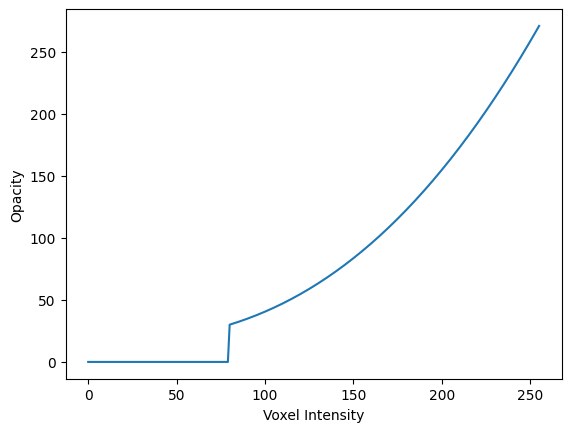

In [16]:
opacity_tf = np.linspace(0.0, 1.0, 256)
opacity_tf = 255.0 * (opacity_tf ** 2.5) + 16
opacity_tf[0:80] = 0

plt.plot(opacity_tf)
plt.xlabel("Voxel Intensity")
plt.ylabel("Opacity")
plt.show()

In [17]:
wnd.add_volume(grid, opacity=opacity_tf)

<Volume(0x7fc1a141cc00) at 0x7fc0dc974e20>

In [18]:
wnd.clear()

Finally, we can also adjust the color map, which is used for rendering!

In [19]:
wnd.add_volume(grid, opacity=opacity_tf, cmap='bone')

<Volume(0x7fc19ec38a00) at 0x7fc17dbd8ee0>

# Exercise 3: Enface Projection Maps

Besides direct volume rendering, another way to visualize OCT data efficiently is through so-called "enface" maps. These maps are 2D axial projection maps that extract features along each A-scan. The most typical enface maps are average, maximum, argmax, centroid or surface maps. In this exercise we will generate a few of them and inspect the differences. In practice these maps would be generated on a GPU (<1ms), however for practical reasons we are doing this in Python today.

### 2D Average Projection Map

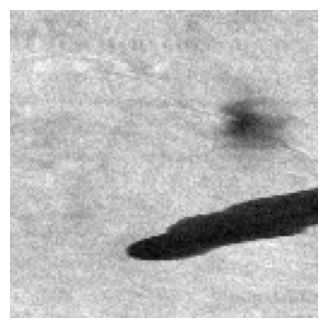

In [20]:
enface = np.mean(volume, axis=1)
enface = cv2.resize(enface,(128, 128))
plt.figure(figsize=(4, 4))
plt.imshow(enface, cmap='gray')
plt.axis('off')
plt.show()

### 2D Maximum Projection Map

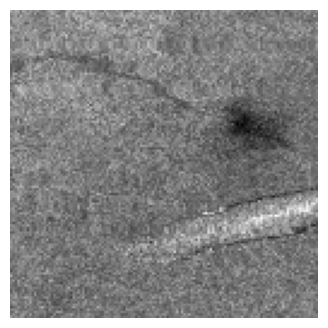

In [21]:
enface = np.max(volume, axis=1)
enface = cv2.resize(enface,(128, 128))

plt.figure(figsize=(4, 4))
plt.imshow(enface, cmap='gray')
plt.axis('off')
plt.show()

### Surface Depth Map

Surface maps can be very helpful to extract and analyze 3D geometry, for example of the surgical instrument. However, these maps are sometimes quite noisey and depend on an intensity threshold, which defines the surface. We also need to write our own method to generate this map. In Python, iterating through a volume data would be slow. Luckily, we can use numba to convert our python code into machine code and make our map generation "lightning fast".

In [22]:
from numba import njit

In [23]:
@njit()
def generate_surface_depth_map(volume, dst, threshold):
    
    for r in range(volume.shape[0]):
        for c in range(volume.shape[2]):
            depth = 0
            for d in range(volume.shape[1]):
                if volume[r, d, c] > threshold:
                    depth = float(d) / float(volume.shape[1])
                    break
                    
            dst[r, c] = depth
            
    return dst

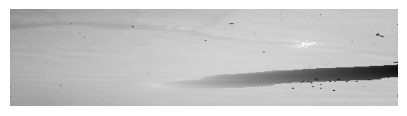

In [24]:
enface = np.zeros([volume.shape[0], volume.shape[2]])
enface = generate_surface_depth_map(volume, enface, 60.0)

plt.figure(figsize=(5, 5))
plt.imshow(enface, cmap='gray')
plt.axis('off')
plt.show()

We can also build an interactive Slider to play around with the values!

In [25]:
def get_surface_depth_map(surface_threshold):
    
    surface_map = np.zeros([volume.shape[0], volume.shape[2]])
    surface_map = generate_surface_depth_map(volume, surface_map, surface_threshold)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(surface_map, cmap='gray')
    plt.axis('off')
    plt.show()

In [27]:
slider = IntSlider(min=0, max=255, step=1, value=0, description='Threshold')
interact(get_surface_depth_map, surface_threshold=slider)

interactive(children=(IntSlider(value=0, description='Threshold', max=255), Output()), _dom_classes=('widget-i…

<function __main__.get_surface_depth_map(surface_threshold)>

# Exercise 4: Instrument Segmentation

We can leverage these 2D projection maps to extract geometry or even to generate approximate segmentation maps. We will now create a second surface map function, but this time looking at the volume from the bottom. Using both, the surface map and the bottom surface map, we can segment the instrument by the distance between top and bottom surface. This is only possible because of the OCT instrument shadowing artifact.
![SegmentationApproach](./images/InstrumentSeg.png)

In [28]:
@njit()
def generate_bottom_surface_depth_map(volume, dst, threshold):
    
    for r in range(volume.shape[0]):
        for c in range(volume.shape[2]):
            depth = 0
            for d in range(volume.shape[1]):
                d_r = volume.shape[1] - d - 1
                if volume[r, d_r, c] > threshold:
                    depth = float(d_r) / float(volume.shape[1])
                    break
                    
            dst[r, c] = depth
            
    return dst

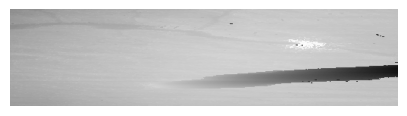

In [29]:
surface = np.zeros([volume.shape[0], volume.shape[2]])
surface = generate_surface_depth_map(volume, enface, 69.0)

plt.figure(figsize=(5,5))
plt.imshow(surface, cmap='gray')
plt.axis('off')
plt.show()

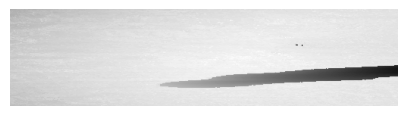

In [30]:
bottom_surface = np.zeros([volume.shape[0], volume.shape[2]])
bottom_surface = generate_bottom_surface_depth_map(volume, bottom_surface, 69.0)

plt.figure(figsize=(5, 5))
plt.imshow(bottom_surface, cmap='gray')
plt.axis('off')
plt.show()

In [31]:
def get_tool_map(threshold):
    
    tool_map = bottom_surface - surface
    bin_map = np.zeros_like(tool_map)
    bin_map[tool_map <= threshold] = 1.0
    
    plt.figure(figsize=(5,5))
    plt.imshow(bin_map, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return bin_map

In [32]:
needle_slider = FloatSlider(min=0.0, max=1.0, step=0.001, value=0, description='Threshold')
interact(get_tool_map, threshold=needle_slider)

interactive(children=(FloatSlider(value=0.0, description='Threshold', max=1.0, step=0.001), Output()), _dom_cl…

<function __main__.get_tool_map(threshold)>

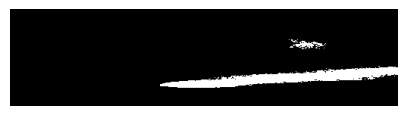

In [33]:
tool_map = get_tool_map(0.03)

# Exercise 4: B-scan Extraction

In this exercise, we aim to extract a B-scan in which the instrument is located, according to the segmentation mask obtained from the previous step. Keep in mind, that the needle is not necessary aligned with the orientation of the B-scans, and different parts of needle can be appeared in a set of ‌B-scans. Therefore, we need to find out the plane, in which contains the needle, and visualize it by interpolation among the B-scans we have.

The steps that we are going to take are shown in the figure below. You have already done steps **a** and **b**.

![ABC-scan](./images/b-scan-extraction.png)

In [37]:
from sklearn.linear_model import RANSACRegressor


def fit_line(all_points, shape):

    all_points = np.array(all_points)

    model = RANSACRegressor(random_state=0, stop_probability=0.25, max_trials=200)
    model.fit(all_points[0].reshape(-1, 1), all_points[1])

    min_x = 0
    max_x = shape[0]

    res = np.arange(min_x, max_x)
    points = np.array([res, model.predict(res.reshape(-1, 1))]).transpose([1, 0])[:, [1, 0]]
    points = np.rint(points).astype(int)
    
    return points

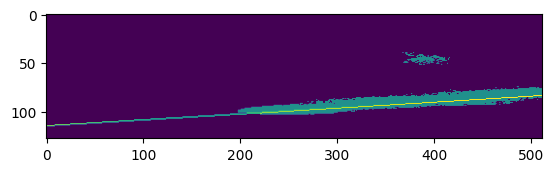

In [40]:
all_points = np.array(np.where(tool_map == 1))
needle_line = fit_line(all_points, tool_map.shape)

k = cv2.line(tool_map.copy(), needle_line[-1], needle_line[0], 2, 1) 
plt.imshow(k)

In [43]:
from sympy import Plane

line_3d = np.insert(needle_line, 1, 0, axis=1).astype(float)
line_3d = line_3d[:, [2, 1, 0]]
line_3d *= voxel_spacing

plane = Plane(list(line_3d[0]),
              list(line_3d[-1]),
              list(line_3d[0] + np.array([0, 100., 0]) * voxel_spacing))


origin = line_3d[0]
normal = np.array(plane.normal_vector, dtype=float)

slice = grid.slice(normal=normal, origin=origin)

wnd.clear()

wnd.add_mesh(grid.outline(), color="k")
wnd.add_mesh(slice)
wnd.add_volume(grid, opacity=opacity_tf * 0.05)

<Volume(0x7fc1a00c2e00) at 0x7fbf727fa340>

In [42]:
wnd.clear()